### Inter-animal variability of giant MFB AZ area measurements - Linear Mixed Model with Bootstrapping  

code authors: katharina lichter, philip kollmannsberger, university and university hospital of wuerzburg, 2022.

this code is used in the manuscript "Ultrastructural analysis of wildtype and RIM1α knock-out active zones in a large cortical synapse"
by k lichter, mm paul, m pauli, s schoch, p kollmannsberger, c stigloher, m heckmann, a-l sirén, 2022.



Import all relevant packages and disable warnings:

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt
import statsmodels.api as sm
import dabest
import multiprocessing as mp
import random

import warnings
warnings.simplefilter('ignore')

Define a function to load data from Excel file:

In [2]:
def load_dataset(directory):

    curr_path = os.getcwd();
    os.chdir(directory);
    
    alldata = pd.read_excel('lichter-et-al_az-area_animal-variability.xlsx', header=0, usecols='B:G')
    
    ko1 = pd.DataFrame.from_dict({'animal': 'KO_1', 'grp': 1, 'area': alldata['RIM1α-KO_1']})
    ko2 = pd.DataFrame.from_dict({'animal': 'KO_2', 'grp': 1, 'area': alldata['RIM1α-KO_2']})
    ko3 = pd.DataFrame.from_dict({'animal': 'KO_3', 'grp': 1, 'area': alldata['RIM1α-KO_3']})

    wt1 = pd.DataFrame.from_dict({'animal': 'WT_1', 'grp': 0, 'area': alldata['RIM1α-WT_1']})
    wt2 = pd.DataFrame.from_dict({'animal': 'WT_2', 'grp': 0, 'area': alldata['RIM1α-WT_2']})
    wt3 = pd.DataFrame.from_dict({'animal': 'WT_3', 'grp': 0, 'area': alldata['RIM1α-WT_3']})
    
    ko = ko1.append(ko2.append(ko3))
    wt = wt1.append(wt2.append(wt3))

    data = ko.append(wt).dropna()
    
    # change index to line numbers
    data.reset_index(inplace=True)
    
    os.chdir(curr_path);
    
    return data

Load dataset:

In [3]:
df = load_dataset('.')
df

,index,animal,grp,area
0,0,KO_1,1,0.094337
1,1,KO_1,1,0.101795
2,2,KO_1,1,0.211067
3,3,KO_1,1,0.097947
4,4,KO_1,1,0.056090
...,...,...,...,...
57,5,WT_3,0,0.045195
58,6,WT_3,0,0.041756
59,7,WT_3,0,0.061615
60,8,WT_3,0,0.070826


----
## 2) Estimation statistics for n = animal
Consider animal as n and perform estimation statistics on the medians of the animals. This approach is underpowered and likely underestimates the effect, because pooling the results of individual animals before applying statistical tests discards much of the information in the data. In addition, the different animals contain different numbers of AZs, and pooling their means or medians might not lead to reliable statistical estimates.

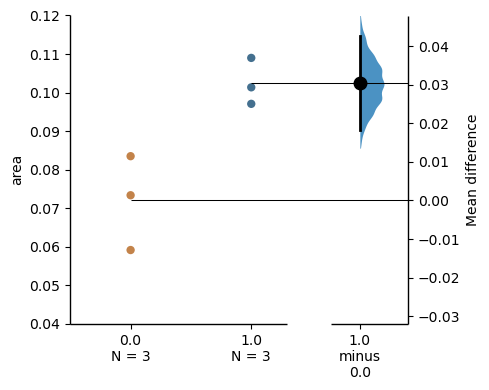

In [19]:
data = df.groupby("animal").median();
data = data.astype({'grp': 'string'})

dabest_area = dabest.load(data=data, x="grp", y="area", idx=("0.0","1.0"))

dabest_area.mean_diff.plot(swarm_ylim=(0.04, 0.12));

---
## 3) Linear Mixed Model
In the second step, we fit a linear mixed model to the data, treating deficiency of RIM1a (RIM1a-KO) as fixed effect and the differences between animals as random effect. This approach both corrects for inter-animal variability and avoids the problem of pooling by using all data points for fitting.

First, select which parameter to fit:

In [5]:
param = "area"

Fit a linear mixed model to the full dataset and show the summary:

In [6]:
# variance component formula: animal variability as random effect
vcf = []
vcf = {"animal": "0+C(animal)"}
oo = np.ones(df.shape[0])

model = []
model = sm.MixedLM.from_formula(f"{param} ~ grp", vc_formula=vcf, groups=oo, re_formula="1", data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
        Mixed Linear Model Regression Results
======================================================
Model:             MixedLM Dependent Variable: area   
No. Observations:  62      Method:             REML   
No. Groups:        1       Scale:              0.0020 
Min. group size:   62      Log-Likelihood:     97.4289
Max. group size:   62      Converged:          Yes    
Mean group size:   62.0                               
------------------------------------------------------
           Coef.   Std.Err.    z   P>|z| [0.025 0.975]
------------------------------------------------------
Intercept  0.077       0.046 1.684 0.092 -0.013  0.167
grp        0.036       0.011 3.127 0.002  0.013  0.058
Group Var  0.002 1387074.411                          
animal Var 0.000                                      
======================================================

"""

Look at the residuals:

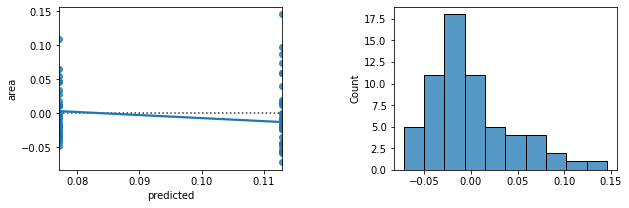

In [7]:
res = pd.DataFrame()
res["predicted"] = model.fittedvalues
res[param] = df[param]

f, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 3), gridspec_kw={'wspace': 0.5});

sns.residplot(x = "predicted", y = param, data = res, lowess=True, ax=ax.flat[0]);
sns.histplot(model.resid.values, ax=ax.flat[1]);

---
## 4) Bootstrapping
To determine confidence intervals of the model coefficients, use bootstrapping of resampled data (10000 repetitions), and derive p values from the confidence intervals of the estimate.

First, define a function to perform k=100 bootstraps:

In [8]:
def get_bootstrap(f=f"{param}~grp", g="animal", df=df, k=100):
    r = np.zeros(k)
    np.random.seed()
    vcf = []
    vcf = {"animal": "0+animal"}
    oo = np.ones(df.shape[0])
    for i in range(k):
        model = []
        s = df.groupby(g).sample(frac=1,replace=True);
        s.reset_index(inplace=True);
        model = sm.MixedLM.from_formula(f, groups=oo, vc_formula=vcf, re_formula="1", data=s).fit()
        r[i] = model.params.grp
    return r

Run 100 processes with 100 bootstraps each using all available cores:

In [9]:
samp = []
pool = mp.Pool(mp.cpu_count())

future_res = [pool.apply_async(get_bootstrap) for i in range(100)]
                               
res = [f.get() for f in future_res]
pool.close()

samp = np.array(res).flatten()

Show the results:

In [10]:
est = np.mean(samp)
l = np.percentile(samp, 2.5)
u = np.percentile(samp, 97.5)
SE = (u-l)/(2*1.96)
z = np.sign(est)*est/SE
p = np.exp(-0.717*z-0.416*z*z)
print(f'Results for {param}:\n');
print('LMM: {0:.3f}\n\nBootstrap: {1:.3f}\n(0.025) {2:.3f}\n(0.975) {3:.3f}\n\np = {4:.3f}'.format(model.params[1],est,l,u,p))

Results for area:

LMM: 0.036

Bootstrap: 0.036
(0.025) 0.015
(0.975) 0.058

p = 0.001


Histogram of all bootstrapped model coefficients:

<AxesSubplot:ylabel='Count'>

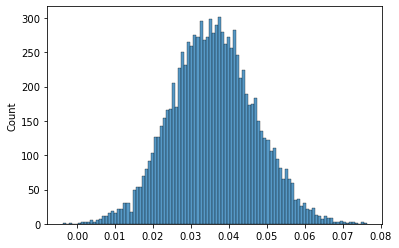

In [11]:
sns.histplot(samp, bins=100)

## 5) Random swapping of labels

Assess the validity of the bootstrapping results by randomly swapping group labels between animals: define a new bootstrap function on the randomized labels. Random swapping is performed every 100 bootstraps; the resulting overall coefficient should be close to zero.

In [12]:
def get_swap_bootstrap(f=f"{param}~rgrp", g="animal", df=df, k=100):
    r = np.zeros(k)
    np.random.seed()
    vcf = []
    vcf = {"animal": "0+animal"}
    oo = np.ones(df.shape[0])
    
    # get random permutation of labels
    a = df.groupby("animal").grp.max().values
    np.random.shuffle(a)

    # assign random labels to new column "rgrp":
    for i,key in enumerate(df["animal"].unique()):
        df.loc[df["animal"].str.contains(key),'rgrp'] = a[i]

    for i in range(k):
        model = []
        s = df.groupby(g).sample(frac=1,replace=True);
        s.reset_index(inplace=True);
        model = sm.MixedLM.from_formula(f, groups=oo, vc_formula=vcf, re_formula="1", data=s).fit()
        r[i] = model.params.rgrp
    return r

Run 100 processes with 100 bootstraps each using all available cores:

In [13]:
rand_samp = []
pool = mp.Pool(mp.cpu_count())
future_res = [pool.apply_async(get_swap_bootstrap) for i in range(100)]
res = [f.get() for f in future_res]
pool.close()
rand_samp = np.array(res).mean(axis=1)

Plot histogram of means of all randomized coefficients:

-1.3407729084093827e-03

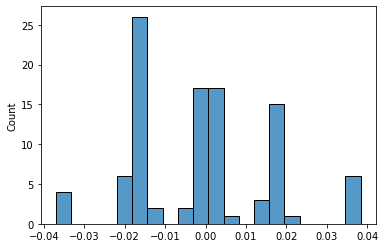

In [14]:
rand_samp = np.array(res).mean(axis=1)

sns.histplot(rand_samp, bins=20)
np.mean(rand_samp)